In [1]:
import torch
import emoji
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../')

from tqdm import tqdm
from config import GPT2EmojiConfig
from model import GPT2LMEmojiModel
from transformers import GPT2Tokenizer
from run_language_modeling import load_and_cache_examples, targets_mask
from sst_binary import sst_binary
from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


MODEL_CLASSES = {
    "gpt2": (GPT2EmojiConfig, GPT2LMEmojiModel, GPT2Tokenizer),
}

MODEL_PATH = '../checkpoint-180000'

args = torch.load(os.path.join(MODEL_PATH, 'training_args.bin'))

config_class, model_class, tokenizer_class = MODEL_CLASSES['gpt2']

config = config_class.from_pretrained(MODEL_PATH)

tokenizer = tokenizer_class.from_pretrained(MODEL_PATH)

model = model_class.from_pretrained(
            MODEL_PATH,
            config=config,
)

map_target_to_token_id = dict(
        zip(range(0, len(emoji.UNICODE_EMOJI.keys())), tokenizer.encode(list(emoji.UNICODE_EMOJI.keys())))
)


Bad key "text.kerning_factor" on line 4 in
/home/jkarabl/anaconda3/envs/emoji-gpt2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Token indices sequence length is longer than the specified maximum sequence length for this model (2811 > 1024). Running this sequence through the model will result in indexing errors


In [2]:
DATASETS = [
    'Olympic',
    'PsychExp',
    'SCv1',
    'SCv2-GEN',
    'SE0714',
    'SS-Twitter',
    'SS-Youtube',
]
DIR = '../data'
FILENAME_RAW = 'raw.pickle'
CLASSES = 'not sarcastic, sarcastic'.split(', ')
TRAIN_SIZE = 1000

In [3]:
def load_dataset(dataset):
    print(dataset)
    DATASET_PATH = f'{DIR}/{dataset}/{FILENAME_RAW}'
    with open(DATASET_PATH, 'rb') as file:
        data = pickle.load(file, fix_imports=True, encoding='bytes')
    
    # Decode data
    texts = [str(x) for x in data[b'texts']]
    # Extract labels
    labels = [x[b'label'] for x in data[b'info']]
    return texts, labels

def decode(y_in):
    y_out = []
    for y in y_in:
        y_out.append(np.argmax(y))
    return y_out

In [4]:
X, y = load_dataset(DATASETS[2])

SCv1


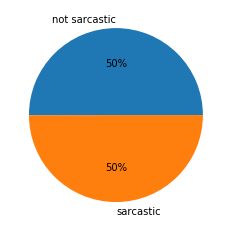

In [5]:
df = pd.DataFrame({'X': X, 'y': y})
ax = df.y.value_counts().plot.pie(labels=CLASSES, autopct='%1.0f%%')
ax.set_ylabel(None)
plt.savefig('SCv1-classes.pdf', dpi=300)

In [6]:
pd.set_option('display.max_colwidth', 1000)

In [7]:
df.loc[df.y == 0]

,X,y
998,"b'Is it correct to assume that in the presence of the precursors of the standard genetic code (e.g. intermediates of glucose degradation and the citric acid cycle), the intimate relationship between these molecules resulted in the inevitable organization of the genetic code (global optimum of the system)? Articles 5-7 These articles discuss fascinating mathematical representation of the genetic code. For example, in article 6 a representation of the genetic code as a six\xe2\x80\x93dimensional Boolean hypercube is proposed. Abstract:'",0
999,"b""President Obama has correctly characterized the Bill of Rights is a list of negative Rights against government. The point is, that the only rights that the government, and or any anti-gunner, or department has, is the infringements we grant them through laws etc. Taking the info in this article at face value. What was a legal practice to do just yesterday landed this guy in a jackpot for not knowing what or how the Govt. is going to interpret the law to mean today. This is a common problem with, and not to directly pick on the ATF, but gun dealers complain about this all the time. EVEN an FBI agent himself cannot predict, nor curry a favorable interpretation. What kind of country and legal system do we want? Surely you can see that this kind of stuff is not in ANY WAY Shape of Form, fair to do to a Right that our Constitution says is Inalienable. Or to a person who was an impeccable reputation. Would you like to be treated in this manner? The article says, what he did i...",0
1000,"b'When talking to a person professing Christianity, the Bible is binding. If the Bible advises that abortion is murder, then it is so regardless of what the secular systems of the day have to say about it. When talking with one accepting the principles of Christianity, the premiere of those being that the Bible is binding, the existence of the soul is not up for debate. The position of Bassman, I believe, would be that there is no legitimate right to terminate a pregnancy, especially from the stand-point of the Bible, which of course, is binding to those professing Christianity.'",0
1001,b'Good idea!',0
1002,"b'No, they do not. I know several people in England who posess weapons the bought on the street. How are the gun laws in england working when you can buy a machine gun? Before the ban, england had lower numbers when it came to firearms related deaths. They also had lower crime numbers. The sociological differences between England and the United States are not be be discounted. It is interesting to note that crime rates in England seem to be rising now that the gun ban has been around for a while. There is even a movement by public officials to arm police officers in response to the rising rate of violent crime. There isa n article and debate about it right here on the forums. The biggest difference lately in the statistics in England in the US is not the numbers, it is how they are recorded. If a guy is confronted by three people outside a bar and shot to death, but the gus get off during trial, it is still recorded in America s a three person homocide. In england, it is NOT ...",0
...,...,...
1990,"b'Please define ""climb upward"" and ""downhill slide"" in biologically meaningful terms. Please define ""degeneration.""'",0
1991,"b'Actually, I think Kronos is right in this case--at least from the standpoint of most consitutional scholars. Of course the framers didn\'t envision the wording to be used in this way for this purpose--this is what\'s simply called a ""loophole"", in this case anyway. It\'s why there has been an effort in recent years to close the loophole with a constitutional amendment defining marriage.'",0
1992,b'But we have an enumerated Constitutional RKBA. Apples to oranges.',0
1993,"b""And what does it matter if they're in the army reserve, or a lawyer, a teacher, a doctor?""",0


In [8]:
df.loc[df.y == 1]

,X,y
0,"b""So in order to discuss an article you made up a bunch of stuff that wasn't in the article, implied it was in the article, and failed to discuss anything that was actually in the article. I see. Will this be a one time thing, or is this the sort of thing we should expect from you on a regular basis? Just wondering.""",1
1,"b""Old habits die hard and dogs don't pay attention to clocks!""",1
2,"b'They only need 1/4 of the legislature, so they\'ll probably get that. But if it actually gets to the polls? The conservatives took a big hit when they ran around screaming ""If gays get married society will collapse and we\'ll all be doomed!!!11!1!!"" and then nothing happened. And of course the most organized group in Mass. opposing gay marriage is the Mass. Catholic church, and people aren\'t going to take kindly to a bunch of child rapers telling them what\'s right and wrong. The anti-gay side really doesn\'t have much to work with; it\'ll largely be a contest of good will and common sense vs. scare tactics, and the scare tactics have already been proven wrong.'",1
3,b'well if you think the sun goes around the earth then its time for apocalypse.',1
4,"b'I dunno. What is the scoop here? You complain about the responses we give, and yet you keep coming back for more. Even people with down syndrome learn enough to only stick their hands in the open flame once.'",1
...,...,...
993,"b'That money will never be paid. ""Doctor"" Hovind (his doctorate is from an unaccredited diploma mill) has phrased his offer in such a way that it is impossible to get it. Numbers 1-4 have absolutely nothing to do with evolution, but gullable people fall for it. Number 1 is actually impossible to prove. Hovind probably doesn\'t even have $250,000. In 1996 he declared bankruptcy, and there\'s no reason to believe that his financial situation has suddenly improved. He claims that ""a wealthy friend"", whom he refuses to name, has the money. The committee that is supposed to evaluate claims is similarly anonymous, but he has hinted that it\'s filled exclusively with creationists, who are certainly not unbiased. Read about Kent Hovind. He really is a worthless piece of scum.'",1
994,"b'That ""somebody"" was a Jesuit priest, the idea met some initial resistance because of it\'s religious overtones. But the overwhelming evidence in favor of it carried the day. You should study some history too.'",1
995,"b""Try the link. You've done the 'name calling', at least you could be honest about what you are doing.""",1
996,"b""That's great for women! What about the rights of their children?""",1


In [7]:
Xt = tokenize(X, tokenizer)

In [8]:
trXt, teXt, trY, teY = train_test_split(Xt, y, train_size=TRAIN_SIZE, random_state=42)

In [9]:
mean_preds = predict_mean(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 1000/1000 [09:00<00:00,  1.85it/s]


In [10]:
last_preds = predict_last(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


In [11]:
max_preds = predict_max(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]


In [12]:
mean_cm = pd.crosstab(pd.Series(mean_preds), pd.Series(trY))
mean_cm

col_0,0,1
row_0,,
✊,1,0
✨,3,4
❤,1,1
🌟,1,0
🎶,3,2
👀,3,4
👇,6,1
👍,5,0
👏,0,2


In [13]:
last_cm = pd.crosstab(pd.Series(last_preds), pd.Series(trY))
last_cm

col_0,0,1
row_0,,
☕,1,0
♥,1,2
✨,4,8
❤,6,5
➡,1,0
🇺,2,1
🌊,1,0
🍀,1,0
🎂,1,0


In [14]:
max_cm = pd.crosstab(pd.Series(max_preds), pd.Series(trY))
max_cm

col_0,0,1
row_0,,
☕,1,0
♥,0,1
✅,1,1
✊,1,0
✨,1,0
🇺,7,0
🌊,2,3
🌍,0,1
🌙,0,1


In [15]:
cramers_corrected_stat(mean_cm.to_numpy())

0.05194106241580205

In [16]:
cramers_corrected_stat(last_cm.to_numpy())

0.06577998057719492

In [17]:
cramers_corrected_stat(max_cm.to_numpy())

0.07627970516550639

In [18]:
theil_u(trY, mean_preds)

0.021170448238826335

In [19]:
theil_u(trY, last_preds)

0.0281494470867897

In [20]:
theil_u(trY, max_preds)

0.04645914166334241

## Logreg

In [21]:
Xtrans_last = transform_last(X, model, tokenizer, args)

100%|██████████| 1995/1995 [05:43<00:00,  5.81it/s]


In [22]:
Xtrans_mean = transform_mean(X, model, tokenizer, args)

100%|██████████| 1995/1995 [06:00<00:00,  5.53it/s]


In [23]:
Xtrans_max = transform_max(X, model, tokenizer, args)

100%|██████████| 1995/1995 [06:20<00:00,  5.24it/s]


In [24]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_last, y, train_size=TRAIN_SIZE, random_state=42)

In [25]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
model, C, scores

(LogisticRegression(C=0.015625, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.015625,
 [0.648212424137123,
  0.6472304797229116,
  0.6492448139988949,
  0.6442207461637294,
  0.6301324476552967,
  0.6120410999862623,
  0.6029749728514786,
  0.6070335881764124,
  0.5989884940439936])

In [26]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_mean, y, train_size=TRAIN_SIZE, random_state=42)

In [27]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
model, C, scores

(LogisticRegression(C=0.0078125, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.0078125,
 [0.6170715028146778,
  0.6451558804601604,
  0.6341261374840389,
  0.63008760870268,
  0.6280952496403692,
  0.6271356783919599,
  0.6271296523566958,
  0.6060106507632508,
  0.5929500226770197])

In [28]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_max, y, train_size=TRAIN_SIZE, random_state=42)

In [29]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
model, C, scores

(LogisticRegression(C=0.03125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.03125,
 [0.5928842254571245,
  0.5969702693666292,
  0.5989803927114341,
  0.6120567748400025,
  0.608039805095634,
  0.5979895436878297,
  0.5899161972798461,
  0.5909481630975072,
  0.5768690359185809])

## Vanilla GPT-2

In [5]:
from transformers import GPT2Model

In [6]:
model_version = 'gpt2'
model_gpt2 = GPT2Model.from_pretrained(model_version)
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained(model_version)

In [7]:
Xtrans_gpt2 = transform_gpt2(X, model_gpt2, tokenizer_gpt2)

100%|██████████| 1995/1995 [12:47<00:00,  2.60it/s]


In [8]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_gpt2, y, train_size=TRAIN_SIZE, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.03125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.03125,
 [0.6592951058613908,
  0.6613065326633166,
  0.6673366834170854,
  0.6762638632909755,
  0.6723350007677202,
  0.6603011644162162,
  0.6592964824120604,
  0.6452261306532664,
  0.6361775971297433])

In [9]:
Xtrans_emoji = transform_emoji(X, model, tokenizer)

100%|██████████| 1995/1995 [08:35<00:00,  3.87it/s]


In [10]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_emoji, y, train_size=TRAIN_SIZE, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.03125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.03125,
 [0.6422078027021785,
  0.6411697855898175,
  0.6451343697367771,
  0.6502424242424243,
  0.6461879131713784,
  0.6231094868834526,
  0.6090452261306533,
  0.5969832963139166,
  0.5909398993322148])